# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [ ]:
#
# Add your code here
#
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
from tensorflow.keras.utils import plot_model

# For model B
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.models import Model

drive.mount("/content/drive")

#notes:
#use validation data for hyperparameter tuning, not the test data 
#using relu until the end (where we ue sigmoid) to avoid the vanishing gradient problem
#mess around with drop out 
#batch normalisation (try before and after the activation function) reduces the vanishing gradient problem (can try more complex models)
#dense layers drop out is better, for the convolutional layers batch normalisation is better
#look at fine tuning for the pre-trained model (dont freeze all the convolutional layers)
#when fine tuning use a lower learning rate (you dont want to make huge changes)
#for pretrained models we can use any classifier, like svm etc... maybe mess around with this 
#image augmentation 

Mounted at /content/drive


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

Age: 40  Gender: 0  Race: 3
/content/drive/My Drive/train_val/40_0_3_20170119183403621.jpg.chip.jpg


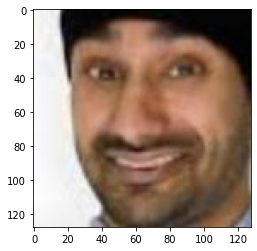

Age: 75  Gender: 0  Race: 0
/content/drive/My Drive/train_val/75_0_0_20170117174511134.jpg.chip.jpg


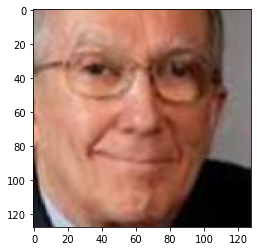

Age: 18  Gender: 1  Race: 0
/content/drive/My Drive/train_val/18_1_0_20170109213011914.jpg.chip.jpg


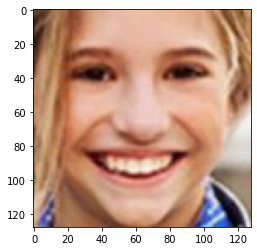

Age: 70  Gender: 1  Race: 3
/content/drive/My Drive/train_val/70_1_3_20170116224931319.jpg.chip.jpg


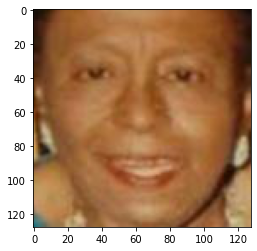

Age: 26  Gender: 1  Race: 1
/content/drive/My Drive/train_val/26_1_1_20170116232602440.jpg.chip.jpg


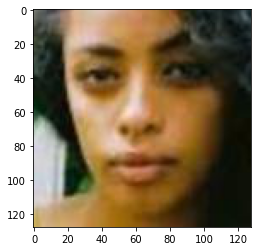

Age: 23  Gender: 0  Race: 1
/content/drive/My Drive/train_val/23_0_1_20170114033532450.jpg.chip.jpg


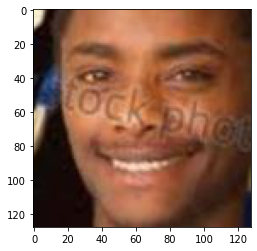

Age: 4  Gender: 0  Race: 0
/content/drive/My Drive/train_val/4_0_0_20170109191251137.jpg.chip.jpg


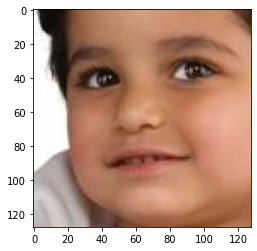

Age: 1  Gender: 1  Race: 4
/content/drive/My Drive/train_val/1_1_4_20161221192615380.jpg.chip.jpg


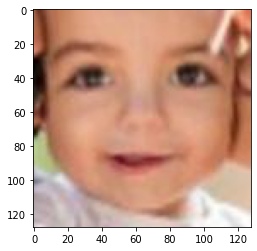

Age: 28  Gender: 0  Race: 2
/content/drive/My Drive/train_val/28_0_2_20170107212142294.jpg.chip.jpg


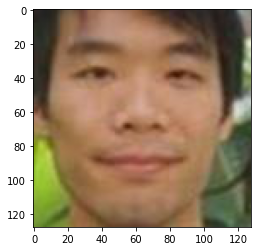

Age: 72  Gender: 1  Race: 0
/content/drive/My Drive/train_val/72_1_0_20170110182012800.jpg.chip.jpg


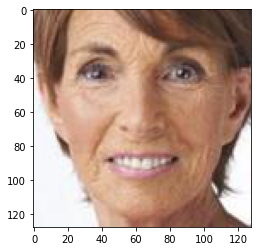

Age: 26  Gender: 1  Race: 1
/content/drive/My Drive/train_val/26_1_1_20170113011732808.jpg.chip.jpg


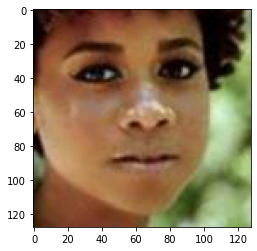

Age: 34  Gender: 0  Race: 1
/content/drive/My Drive/train_val/34_0_1_20170113135659457.jpg.chip.jpg


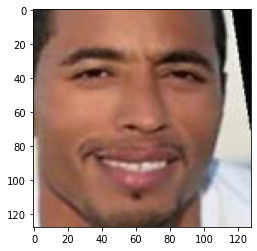

Age: 25  Gender: 0  Race: 0
/content/drive/My Drive/train_val/25_0_0_20170117195027938.jpg.chip.jpg


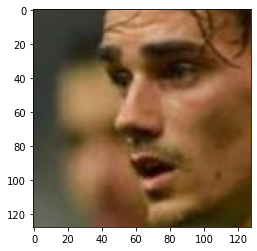

Age: 3  Gender: 1  Race: 4
/content/drive/My Drive/train_val/3_1_4_20170103205816397.jpg.chip.jpg


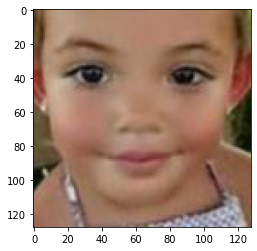

Age: 54  Gender: 0  Race: 3
/content/drive/My Drive/train_val/54_0_3_20170119210214520.jpg.chip.jpg


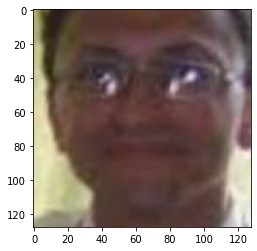

Age: 45  Gender: 0  Race: 3
/content/drive/My Drive/train_val/45_0_3_20170119201303715.jpg.chip.jpg


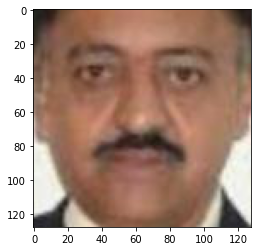

Age: 13  Gender: 0  Race: 2
/content/drive/My Drive/train_val/13_0_2_20170103201143159.jpg.chip.jpg


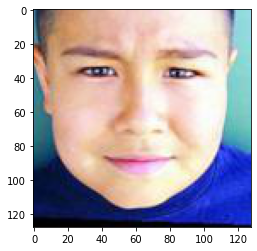

Age: 24  Gender: 1  Race: 3
/content/drive/My Drive/train_val/24_1_3_20170104222753607.jpg.chip.jpg


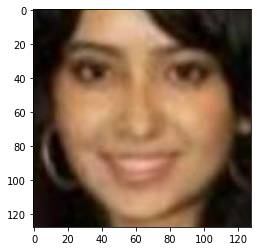

Age: 4  Gender: 0  Race: 0
/content/drive/My Drive/train_val/4_0_0_20170110213211374.jpg.chip.jpg


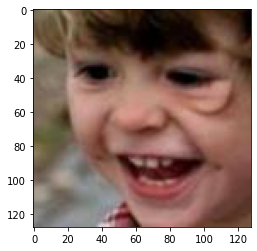

Age: 56  Gender: 1  Race: 0
/content/drive/My Drive/train_val/56_1_0_20170110122842545.jpg.chip.jpg


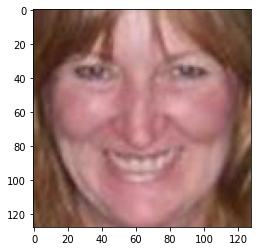

                                                   path  age  gender
0     /content/drive/My Drive/train_val/40_0_3_20170...   40       0
1     /content/drive/My Drive/train_val/75_0_0_20170...   75       0
2     /content/drive/My Drive/train_val/18_1_0_20170...   18       1
3     /content/drive/My Drive/train_val/70_1_3_20170...   70       1
4     /content/drive/My Drive/train_val/26_1_1_20170...   26       1
...                                                 ...  ...     ...
4995  /content/drive/My Drive/train_val/73_0_0_20170...   73       0
4996  /content/drive/My Drive/train_val/21_0_1_20170...   21       0
4997  /content/drive/My Drive/train_val/45_0_1_20170...   45       0
4998  /content/drive/My Drive/train_val/63_1_0_20170...   63       1
4999  /content/drive/My Drive/train_val/24_0_2_20170...   24       0

[5000 rows x 3 columns]


In [ ]:
#
# Add your code here
#

path_list = list(Path("/content/drive/My Drive/train_val").rglob("*.jpg"))
y = []

for idx, path in list(enumerate(path_list)):
     # Because path is object not string
     image_txt = str(path).split("val/")[1]
     data_y = image_txt.split("_")
     age, gender, race = data_y[:3]
     y.append((str(path), int(age), int(gender)))
     if idx < 20:
      print(f"Age: {age}  Gender: {gender}  Race: {race}")
      print(path)
      image = Image.open(str(path))
      plt.figure(figsize=(4, 4))
      plt.imshow(image)
      plt.show()

df = pd.DataFrame(y, columns=["path", "age", "gender"])
print(df)

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
train_df = df.sample(frac=0.8)
test_df = df.drop(train_df.index)
val_df = train_df.sample(frac=0.25)
train_df = train_df.drop(val_df.index)

batch_size = 64

datagen_test = ImageDataGenerator(
    rescale=1./225,
    )
datagen_train = ImageDataGenerator(
    rescale=1./225,
    rotation_range=20,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    # # vertical_flip=True,
    fill_mode="nearest"
)
datagen_val = ImageDataGenerator(
    rescale=1./225
    )

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    target_size=(128, 128),
    batch_size=batch_size,
    x_col="path",
    y_col=["age", "gender"],
    class_mode="multi_output") 

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    target_size=(128, 128),
    batch_size=batch_size,
    x_col="path",
    y_col=["age", "gender"],
    class_mode="multi_output",
    )

# This is a similar generator, for validation data
val_generator = datagen_val.flow_from_dataframe(
    dataframe=val_df,
    target_size=(128, 128),
    shuffle=False,
    batch_size=batch_size,
    x_col="path",
    y_col=["age", "gender"],
    class_mode="multi_output",
    )

NameError: ignored

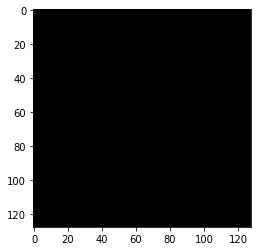

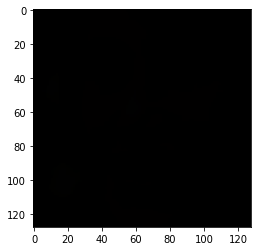

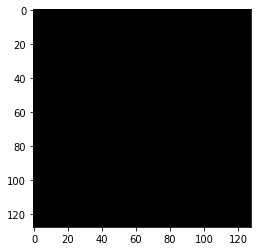

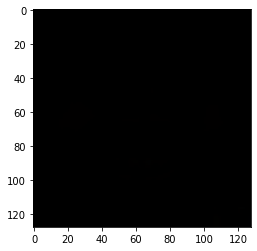

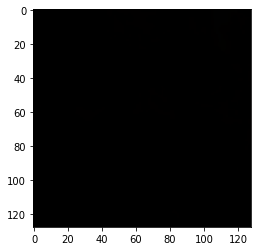

In [ ]:
for _ in range(5):
    img, label = train_generator.next()
    plt.imshow(img[0].astype('uint8'))
    plt.show()

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [ ]:
#
# Add your code here
#

# See above cell for pre-processing

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d_8[0][0]']               
                                )                                                           

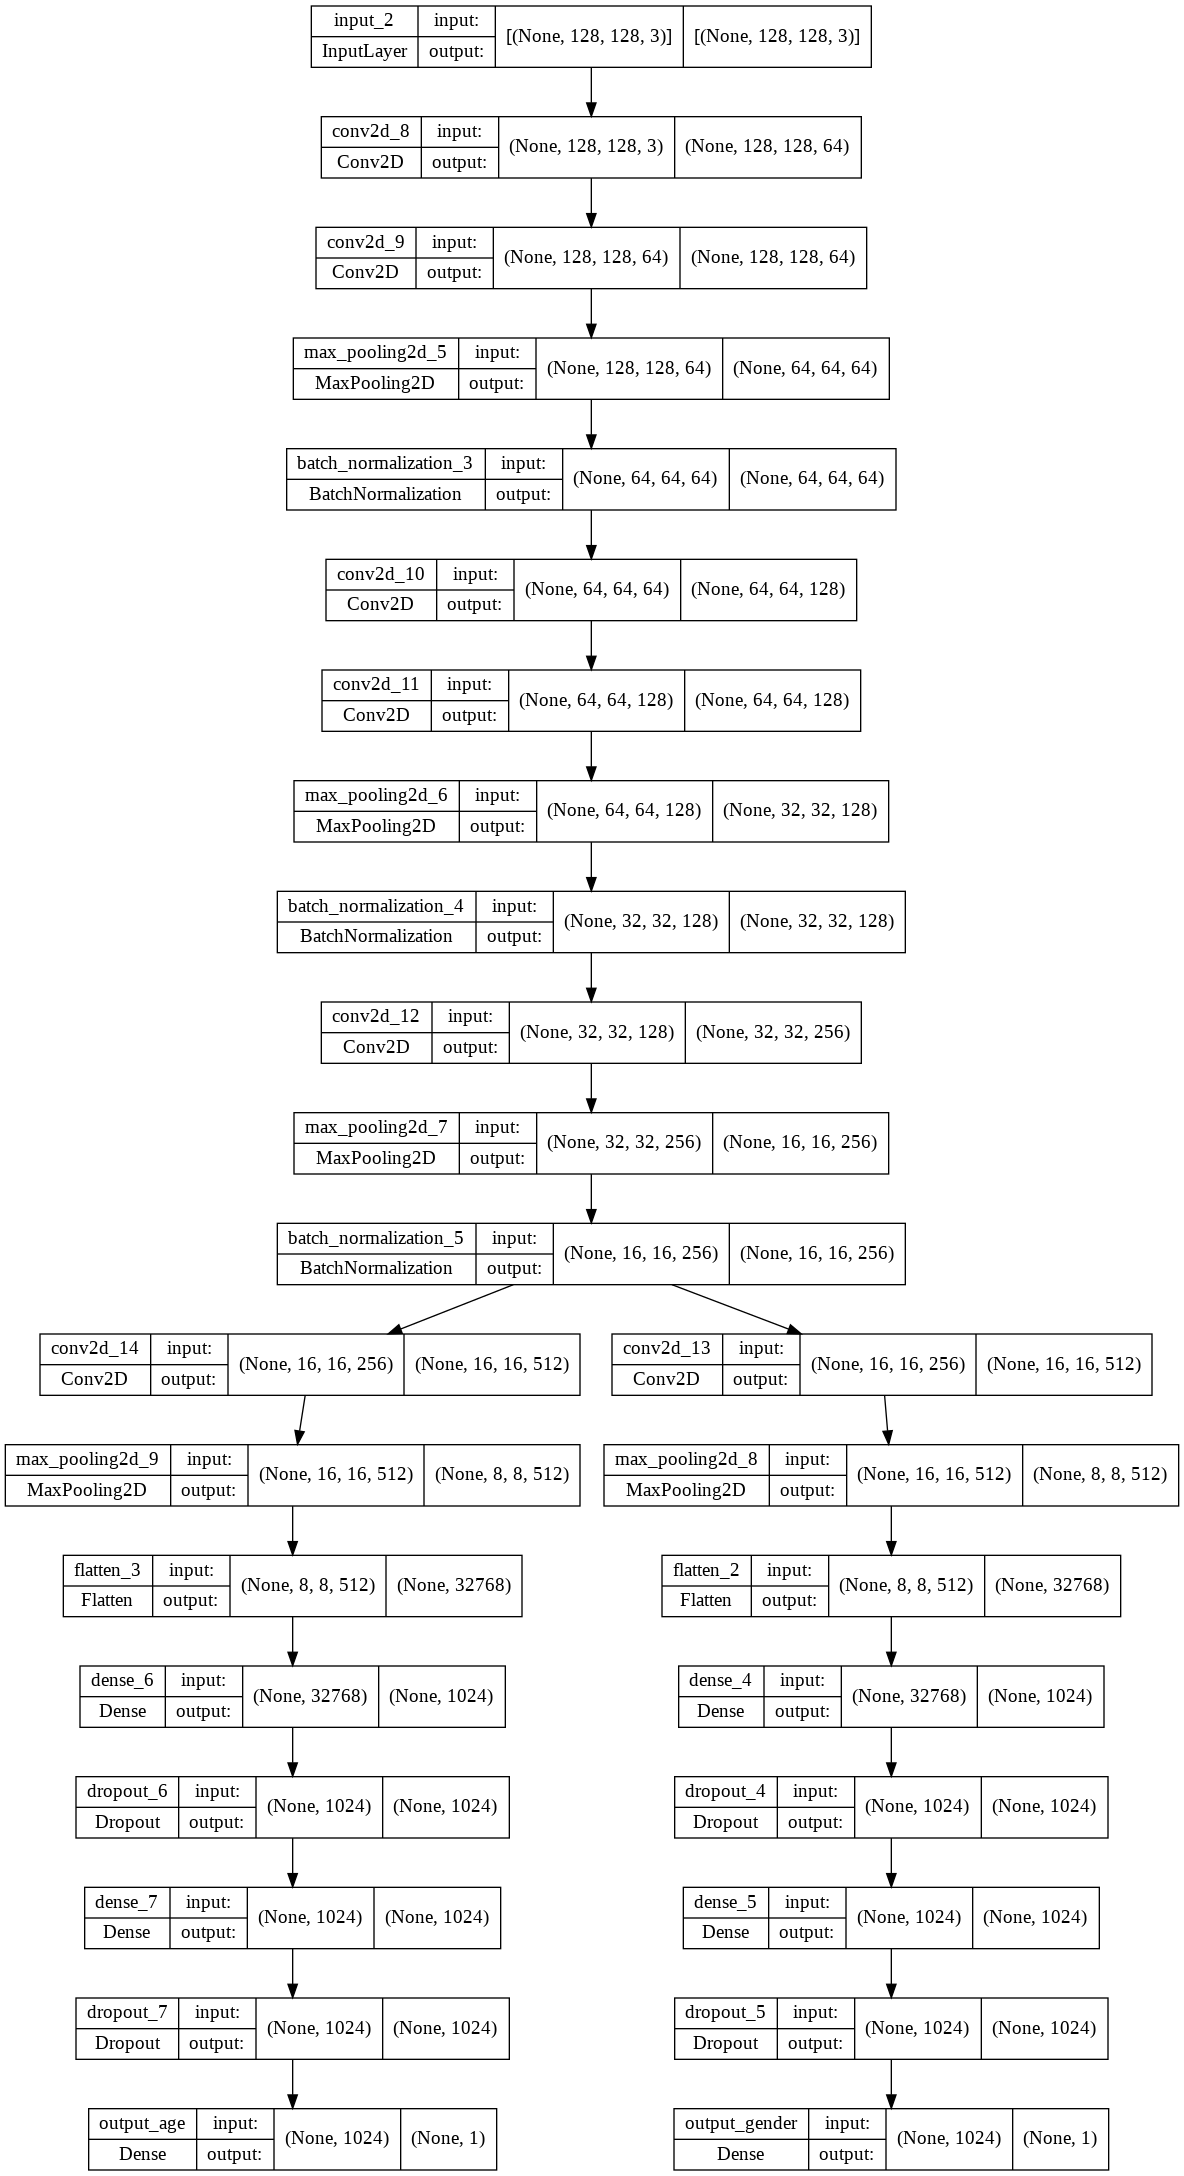

In [ ]:
input_layer = tf.keras.Input(shape=(128, 128, 3))

conv1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input_layer)
conv2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv1)
max1 = layers.MaxPooling2D((2, 2))(conv2)
BN1 = layers.BatchNormalization()(max1)
conv3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(BN1)
conv4 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(conv3)
max2 = layers.MaxPooling2D((2, 2))(conv4)
BN2 = layers.BatchNormalization()(max2)
conv5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(BN2)
max3 = layers.MaxPooling2D((2, 2))(conv5)
BN3 = layers.BatchNormalization()(max3)
# conv6 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(BN3)
# max4 = layers.MaxPooling2D((2, 2))(conv6)

conv3_gender = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(BN3)
max_gender = layers.MaxPooling2D((2, 2))(conv3_gender)
flatten_gender = tf.keras.layers.Flatten()(max_gender)
dense1_gender = tf.keras.layers.Dense(1024, activation="relu")(flatten_gender)
dropout_gender = tf.keras.layers.Dropout(.5)(dense1_gender)
dense2_gender = tf.keras.layers.Dense(1024, activation="relu")(dropout_gender)
dropout2_gender = tf.keras.layers.Dropout(.5)(dense2_gender)

conv3_age = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(BN3)
max_age = layers.MaxPooling2D((2, 2))(conv3_age)
flatten_age = tf.keras.layers.Flatten()(max_age)
dense1_age = tf.keras.layers.Dense(1024, activation="relu")(flatten_age)
dropout_age = tf.keras.layers.Dropout(.5)(dense1_age)
dense2_age = tf.keras.layers.Dense(1024, activation="relu")(dropout_age)
dropout2_age = tf.keras.layers.Dropout(.5)(dense2_age)

output_age = tf.keras.layers.Dense(1, activation="linear", name="output_age")(dropout2_age)
output_gender = tf.keras.layers.Dense(1, activation="sigmoid", name="output_gender")(dropout2_gender)
model_A = tf.keras.Model(inputs=input_layer, outputs=[output_age, output_gender])

model_A.summary()

plot_model(model_A, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:
steps_per_ep = int(len(train_df) * 0.8) // batch_size
val_steps = int(len(test_df) * 0.8) // batch_size

es_callback = callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=30, restore_best_weights=True)

model_A.compile(loss={"output_age": "mean_squared_error", "output_gender": "binary_crossentropy"}, optimizer=optimizers.Adam(learning_rate=0.0001, decay=0.01), metrics={"output_age": "MAE", "output_gender": "accuracy"})
history = model_A.fit(train_generator, callbacks=[es_callback], epochs=24, validation_data=val_generator, steps_per_epoch=steps_per_ep, validation_steps=val_steps)

Epoch 1/24
37/37 [==============================] - 270s 7s/step - loss: 476.5765 - output_age_loss: 475.3084 - output_gender_loss: 1.2679 - output_age_MAE: 16.5584 - output_gender_accuracy: 0.5750 - val_loss: 1275.4973 - val_output_age_loss: 1274.8029 - val_output_gender_loss: 0.6942 - val_output_age_MAE: 29.7357 - val_output_gender_accuracy: 0.5039
Epoch 2/24
37/37 [==============================] - 49s 1s/step - loss: 338.9357 - output_age_loss: 338.2211 - output_gender_loss: 0.7146 - output_age_MAE: 14.0665 - output_gender_accuracy: 0.6424 - val_loss: 1064.9044 - val_output_age_loss: 1064.2135 - val_output_gender_loss: 0.6909 - val_output_age_MAE: 26.6498 - val_output_gender_accuracy: 0.5039
Epoch 3/24
37/37 [==============================] - 21s 581ms/step - loss: 287.4131 - output_age_loss: 286.8633 - output_gender_loss: 0.5498 - output_age_MAE: 12.9377 - output_gender_accuracy: 0.7292 - val_loss: 930.3420 - val_output_age_loss: 929.6533 - val_output_gender_loss: 0.6888 - val_out

In [ ]:
test_loss_all, test_loss_age, test_loss_gender, test_acc_age, test_acc_gender = model_A.evaluate(test_generator)
print("Age MAE:", test_acc_age)
print("Gender accuracy:", test_acc_gender)

16/16 [==============================] - 81s 5s/step - loss: 128.7192 - output_age_loss: 128.4020 - output_gender_loss: 0.3172 - output_age_MAE: 8.3624 - output_gender_accuracy: 0.8550
Age MAE: 8.362434387207031
Gender accuracy: 0.8550000190734863


## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


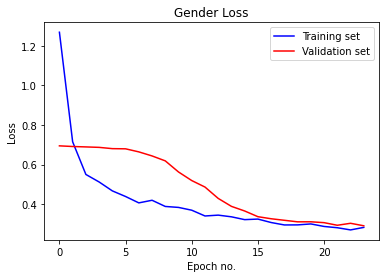

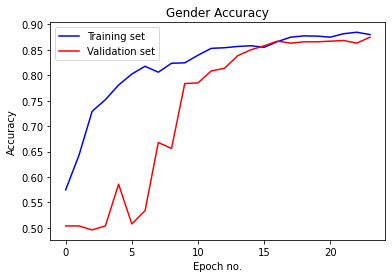

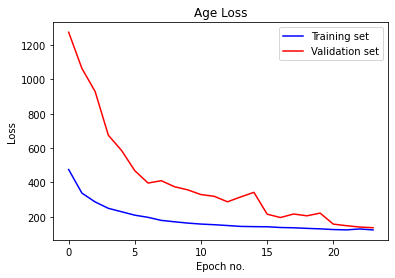

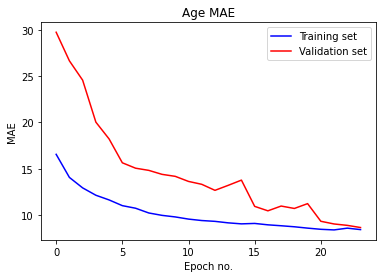

In [ ]:
#
# Add your code here
#

plt.plot(history.history["output_gender_loss"], color="blue", label="Training set")
plt.plot(history.history["val_output_gender_loss"], color="red", label="Validation set")
plt.xlabel("Epoch no.")
plt.ylabel("Loss")
plt.title("Gender Loss")
plt.legend()
plt.show()

plt.plot(history.history["output_gender_accuracy"], color="blue", label="Training set")
plt.plot(history.history["val_output_gender_accuracy"], color="red", label="Validation set")
plt.title("Gender Accuracy")
plt.xlabel("Epoch no.")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["output_age_loss"], color="blue", label="Training set")
plt.plot(history.history["val_output_age_loss"], color="red", label="Validation set")
plt.xlabel("Epoch no.")
plt.ylabel("Loss")
plt.title("Age Loss")
plt.legend()
plt.show()

plt.plot(history.history["output_age_MAE"], color="blue", label="Training set")
plt.plot(history.history["val_output_age_MAE"], color="red", label="Validation set")
plt.xlabel("Epoch no.")
plt.ylabel("MAE")
plt.title("Age MAE")
plt.legend()
plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

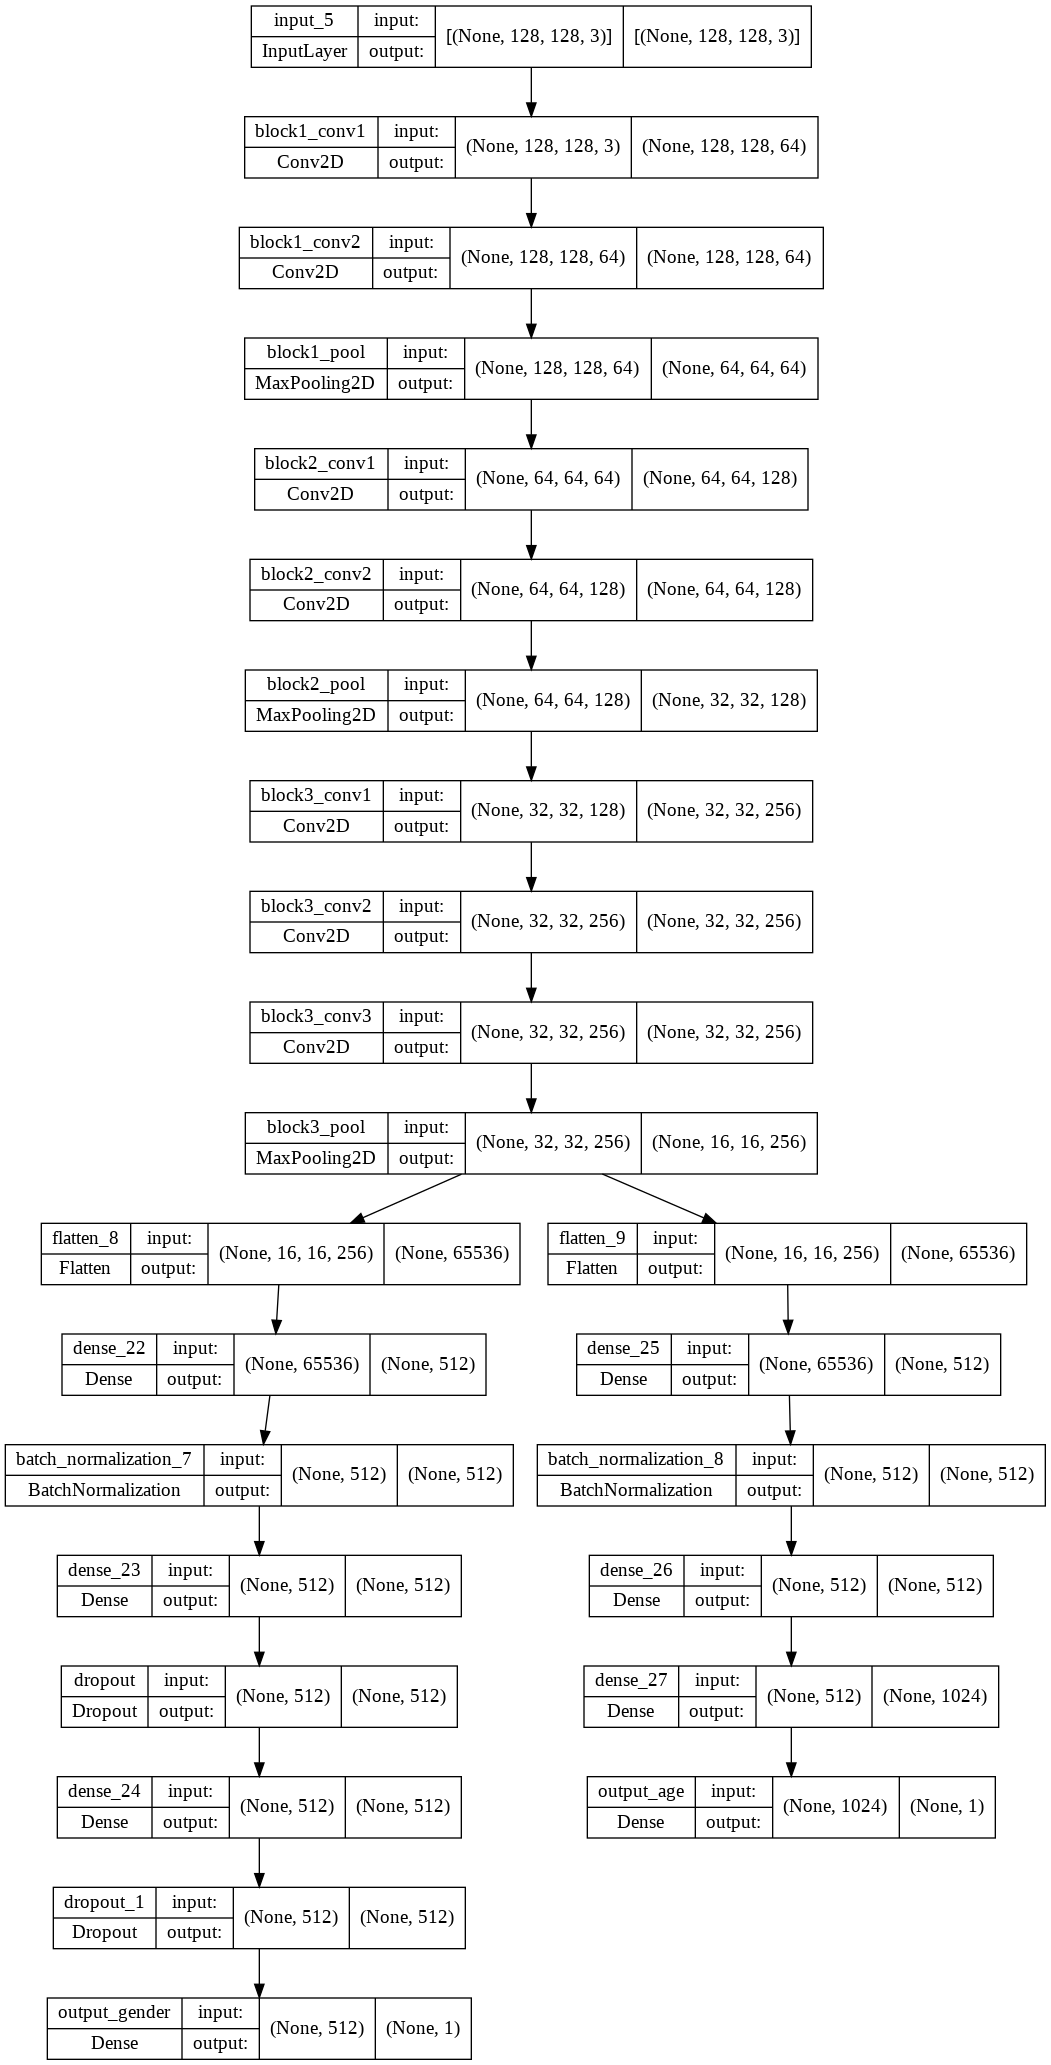

In [ ]:
#
# Add your code here
#

vgg = VGG16(include_top=False, pooling="avg", weights="imagenet", input_shape=(128, 128, 3))

for layer in vgg.layers[:-6]:
  layer.trainable = False

vgg2 = Model(vgg.input, vgg.layers[-10].output)

flatten_gender = tf.keras.layers.Flatten()(vgg2.output)
dense_gender = tf.keras.layers.Dense(512, activation="relu")(flatten_gender)
batch1_norm = layers.BatchNormalization()(dense_gender)
dense1_gender = tf.keras.layers.Dense(512, activation="relu")(batch1_norm)
dropout_gender = tf.keras.layers.Dropout(.5)(dense1_gender)
dense2_gender = tf.keras.layers.Dense(512, activation="sigmoid")(dropout_gender)
dropout2_gender = tf.keras.layers.Dropout(.5)(dense2_gender)

flatten_age = tf.keras.layers.Flatten()(vgg2.output)
dense1_age = tf.keras.layers.Dense(512, activation="relu")(flatten_age)
batch_norm_age1 = layers.BatchNormalization()(dense1_age)
dense2_age = tf.keras.layers.Dense(512, activation="relu")(batch_norm_age1) 
dense3_age = tf.keras.layers.Dense(1024, activation="relu")(dense2_age)

output_age = tf.keras.layers.Dense(1, activation="linear", name="output_age")(dense3_age)
output_gender = tf.keras.layers.Dense(1, activation="sigmoid", name="output_gender")(dropout2_gender)

model_B = tf.keras.Model(inputs=vgg.input, outputs=[output_age, output_gender])

model_B.summary()

plot_model(model_B, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [ ]:
train_generator.reset()
test_generator.reset()
val_generator.reset()

steps_per_ep = int(len(train_df) * 0.8) // batch_size
val_steps = int(len(test_df) * 0.8) // batch_size
es_callback = callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=30, restore_best_weights=True)

opt = optimizers.Adam(learning_rate=0.00001)

model_B.compile(loss={"output_age": "MAE", "output_gender": "binary_crossentropy"}, optimizer=opt, metrics={"output_age": "MAE", "output_gender": "accuracy"})
history = model_B.fit(train_generator, epochs=25, validation_data=val_generator, steps_per_epoch=steps_per_ep, validation_steps=val_steps)

Epoch 1/25
37/37 [==============================] - 21s 530ms/step - loss: 31.8455 - output_age_loss: 31.1434 - output_gender_loss: 0.7021 - output_age_MAE: 31.1434 - output_gender_accuracy: 0.5840 - val_loss: 25.5371 - val_output_age_loss: 25.0502 - val_output_gender_loss: 0.4870 - val_output_age_MAE: 25.0502 - val_output_gender_accuracy: 0.7708
Epoch 2/25
37/37 [==============================] - 19s 513ms/step - loss: 28.3422 - output_age_loss: 27.7748 - output_gender_loss: 0.5675 - output_age_MAE: 27.7748 - output_gender_accuracy: 0.7065 - val_loss: 20.5887 - val_output_age_loss: 20.1756 - val_output_gender_loss: 0.4131 - val_output_age_MAE: 20.1756 - val_output_gender_accuracy: 0.8229
Epoch 3/25
37/37 [==============================] - 20s 544ms/step - loss: 25.0593 - output_age_loss: 24.5874 - output_gender_loss: 0.4719 - output_age_MAE: 24.5874 - output_gender_accuracy: 0.7839 - val_loss: 18.4078 - val_output_age_loss: 18.0334 - val_output_gender_loss: 0.3744 - val_output_age_MAE

In [ ]:
test_loss_all, test_loss_age, test_loss_gender, test_acc_age, test_acc_gender = model_B.evaluate(test_generator)
print("Age MAE:", test_acc_age)
print("Gender accuracy:", test_acc_gender)

16/16 [==============================] - 3s 184ms/step - loss: 6.5386 - output_age_loss: 6.3436 - output_gender_loss: 0.1950 - output_age_MAE: 6.3436 - output_gender_accuracy: 0.9160
Age MAE: 6.3435773849487305
Gender accuracy: 0.9160000085830688


In [ ]:
#
# Add your code here
#

model_B.save("/content/drive/My Drive/age_gender_B_working2.h5")

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

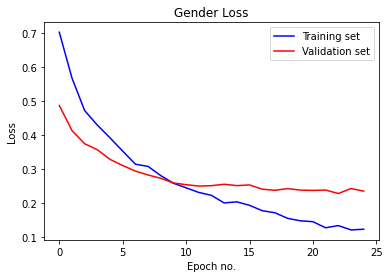

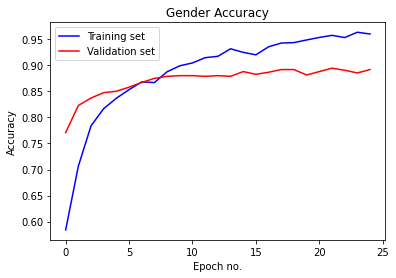

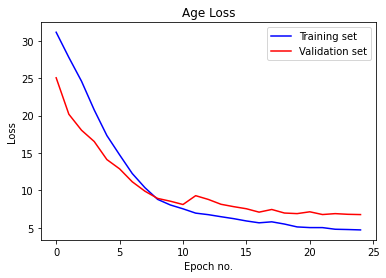

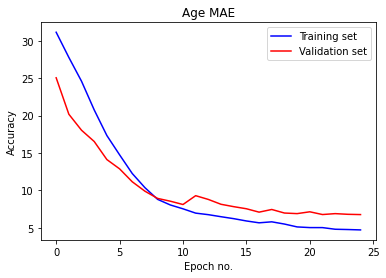

In [ ]:
#
# Add your code here
#

plt.plot(history.history["output_gender_loss"], color="blue", label="Training set")
plt.plot(history.history["val_output_gender_loss"], color="red", label="Validation set")
plt.xlabel("Epoch no.")
plt.ylabel("Loss")
plt.title("Gender Loss")
plt.legend()
plt.show()

plt.plot(history.history["output_gender_accuracy"], color="blue", label="Training set")
plt.plot(history.history["val_output_gender_accuracy"], color="red", label="Validation set")
plt.xlabel("Epoch no.")
plt.ylabel("Accuracy")
plt.title("Gender Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["output_age_loss"], color="blue", label="Training set")
plt.plot(history.history["val_output_age_loss"], color="red", label="Validation set")
plt.xlabel("Epoch no.")
plt.ylabel("Loss")
plt.title("Age Loss")
plt.legend()
plt.show()

plt.plot(history.history["output_age_MAE"], color="blue", label="Training set")
plt.plot(history.history["val_output_age_MAE"], color="red", label="Validation set")
plt.xlabel("Epoch no.")
plt.ylabel("Accuracy")
plt.title("Age MAE")
plt.legend()
plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#